
# Projet : Analyseur de Logs Big Data (4.7M Lignes) en Python

**Objectif :** Démontrer ma capacité à analyser un jeu de données "Big Data" (le dataset BGL de 4.7M lignes) qui ne tient pas en mémoire RAM.

**Problématique :** Un fichier de log de cette taille (plusieurs Go) ne peut pas être chargé d'un coup avec Pandas (`pd.read_csv()`) sur une machine standard (comme Colab ou un PC portable) sans provoquer un "Crash" de mémoire (RAM saturée). Ce projet implémente une solution optimisée.

**Démarche en 5 étapes :**
1.  **Inspection :** Charger un petit échantillon pour comprendre la structure des logs.
2.  **Configuration :** Définir des variables globales pour rendre le script réutilisable.
3.  **Analyse (Comptage) :** Lire le fichier entier par "morceaux" (`chunks`) pour compter les niveaux d'erreur sans saturer la RAM.
4.  **Extraction (Filtrage) :** Isoler les erreurs critiques (`FATAL`) dans un fichier séparé pour une analyse ciblée.
5.  **Enquête (Cause Racine) :** Analyser le fichier d'erreurs propre pour identifier les composants et les messages "coupables".


In [34]:
import pandas as pd
from collections import Counter
import time

In [35]:
# --- CONFIGURATION DU SCRIPT ---
# L'utilisation de variables globales rend le script facile à adapter
# pour un autre fichier de log sans toucher au code principal.

# 1. Le chemin vers le fichier à analyser
FILE_PATH = "/content/BGL.log"

# 2. Le nombre de lignes à lire par morceau (pour la RAM)
# Un "chunk" de 500k lignes est un bon équilibre entre vitesse et utilisation mémoire.
CHUNK_SIZE = 500_000

# 3. Le nombre maximum de "splits" par ligne.
# On limite le split pour regrouper tout le message d'erreur dans la dernière colonne.
SPLIT_LIMIT = 15

# 4. La colonne à analyser (qu'on va trouver à l'étape d'inspection)
# On l'initialise à 'None' pour forcer l'étape d'inspection.
# C'est une sécurité pour ne pas analyser la mauvaise colonne.
COLUMN_TO_ANALYZE = None

# --- FIN DE LA CONFIGURATION ---

print("Configuration chargée.")
print(f"Fichier cible : {FILE_PATH}")

Configuration chargée.
Fichier cible : /content/BGL.log


In [36]:
print("--- Étape 1: Inspection (sur 1000 lignes) ---")

# On utilise 'nrows' pour ne lire qu'un petit échantillon.
# C'est la seule façon d'inspecter un fichier "Big Data" sans saturer la RAM.
try:
    df_sample = pd.read_csv(FILE_PATH,
                            header=None,
                            names=['raw_line'],
                            # 'sep' & 'engine': astuce pour forcer la lecture de chaque ligne
                            # comme une chaîne unique, même si mal formatée.
                            sep='delimiter',
                            engine='python',
                            nrows=1000) # On ne lit que 1000 lignes

    # On applique le même split que celui prévu pour l'analyse
    df_sample_split = df_sample['raw_line'].str.split(expand=True, n=SPLIT_LIMIT)

    # On affiche les 5 premières lignes pour trouver le "patron"
    print("Aperçu de la structure des logs :")
    # .head() est plus lisible et évite d'inonder l'output avec 1000 lignes.
    print(df_sample_split.head())

except FileNotFoundError:
    print(f"ERREUR : Le fichier {FILE_PATH} n'a pas été trouvé.")
except Exception as e:
    print(f"Une erreur est survenue : {e}")

--- Étape 1: Inspection (sur 1000 lignes) ---
Aperçu de la structure des logs :
         0           1           2                    3   \
0      -U01         RAS      KERNEL                FATAL   
1  KERNDTLB  1118556389  2005.06.11  R30-M0-N9-C:J16-U01   
2  KERNDTLB  1118556389  2005.06.11  R30-M0-N9-C:J16-U01   
3  KERNDTLB  1118556389  2005.06.11  R30-M0-N9-C:J16-U01   
4  KERNDTLB  1118556389  2005.06.11  R30-M0-N9-C:J16-U01   

                           4                    5      6          7      8   \
0                        data                  TLB  error  interrupt   None   
1  2005-06-11-23.06.29.011707  R30-M0-N9-C:J16-U01    RAS     KERNEL  FATAL   
2  2005-06-11-23.06.29.234369  R30-M0-N9-C:J16-U01    RAS     KERNEL  FATAL   
3  2005-06-11-23.06.29.384368  R30-M0-N9-C:J16-U01    RAS     KERNEL  FATAL   
4  2005-06-11-23.06.29.486271  R30-M0-N9-C:J16-U01    RAS     KERNEL  FATAL   

     9     10     11         12  
0  None  None   None       None  
1  data   TLB  e

### Conclusion de l'Inspection

L'inspection de l'échantillon (ci-dessus) révèle deux choses :

1.  **Les données sont "sales" :** La première ligne (index 0) n'a pas la même structure que les autres. C'est un cas typique de "bruit" en début de fichier.
2.  **Le "Patron" est trouvé :** À partir de la ligne 1, la structure devient stable. On identifie que :
    * La **colonne 3** contient le composant matériel (ex: `R30-M0-N9-C:J16-U01`).
    * La **colonne 8** contient le niveau de criticité (`FATAL`, `INFO`, etc.).
    * La **colonne 10** contient le début du message d'erreur.

In [37]:
# Mise à jour de notre variable de configuration
COLUMN_TO_ANALYZE = 8

print(f"Configuration mise à jour : Colonne à analyser = {COLUMN_TO_ANALYZE}")

Configuration mise à jour : Colonne à analyser = 8


In [38]:
# On s'assure que la colonne a bien été définie
if COLUMN_TO_ANALYZE is None:
    print("ERREUR : Vous devez d'abord exécuter l'étape d'inspection (Cellules 3 & 5).")
else:
    print(f"--- Étape 3: Démarrage de l'analyse complète (colonne {COLUMN_TO_ANALYZE}) ---")
    start_time = time.time()

    # On crée le compteur ici pour qu'il soit remis à zéro à chaque exécution
    global_counter = Counter()

    try:
        with open(FILE_PATH, "r", encoding="utf-8", errors="ignore") as f:
            lines = []
            chunk_num = 1
            for i, line in enumerate(f, start=1):
                lines.append(line.strip())

                if i % CHUNK_SIZE == 0:
                    print(f"Traitement du morceau {chunk_num}...")
                    # On applique .strip() ici lors de la création du DataFrame pour nettoyer les lignes.
                    chunk_df = pd.DataFrame(lines, columns=["raw_line"])

                    # On utilise les variables de CONFIGURATION
                    cols = chunk_df["raw_line"].str.split(expand=True, n=SPLIT_LIMIT)

                    if cols.shape[1] > COLUMN_TO_ANALYZE:
                        counts = cols.iloc[:, COLUMN_TO_ANALYZE].value_counts()
                        global_counter.update(counts.to_dict())
                    # Étape cruciale : on vide le "seau" (la liste)
                    # pour libérer la RAM avant de traiter le morceau suivant.
                    lines = []
                    chunk_num += 1

            # Traitement du dernier morceau
            if lines:
                print(f"Traitement du dernier morceau (morceau {chunk_num})...")
                chunk_df = pd.DataFrame(lines, columns=["raw_line"])
                cols = chunk_df["raw_line"].str.split(expand=True, n=SPLIT_LIMIT)

                if cols.shape[1] > COLUMN_TO_ANALYZE:
                    counts = cols.iloc[:, COLUMN_TO_ANALYZE].value_counts()
                    global_counter.update(counts.to_dict())

        end_time = time.time()
        print(f"\n--- ANALYSE TERMINÉE EN {end_time - start_time:.2f} SECONDES ---")

    except FileNotFoundError:
        print(f"ERREUR : Le fichier {FILE_PATH} n'a pas été trouvé.")
    except Exception as e:
        print(f"Une erreur est survenue pendant l'analyse : {e}")

--- Étape 3: Démarrage de l'analyse complète (colonne 8) ---
Traitement du morceau 1...
Traitement du morceau 2...
Traitement du morceau 3...
Traitement du morceau 4...
Traitement du morceau 5...
Traitement du morceau 6...
Traitement du morceau 7...
Traitement du morceau 8...
Traitement du dernier morceau (morceau 9)...

--- ANALYSE TERMINÉE EN 43.19 SECONDES ---


In [39]:
print("--- Étape 4: Résultats de l'analyse ---")

if 'global_counter' in locals():
    # On convertit en Série Pandas pour un affichage propre
    final_counts = pd.Series(global_counter).sort_values(ascending=False)

    print("Top 20 des niveaux de logs trouvés :")
    print(final_counts.head(20))
else:
    print("L'analyse (Cellule 6) n'a pas encore été exécutée.")

--- Étape 4: Résultats de l'analyse ---
Top 20 des niveaux de logs trouvés :
INFO            3521574
FATAL            707523
ERROR            112340
WARNING           23332
SEVERE            19198
FAILURE            1714
Kill                306
single                4
microseconds          4
0x00544eb8,           2
dtype: int64


### Étape 5 : Action (Extraction de la Menace)

L'analyse nous a montré qu'il y a **707 523 erreurs FATAL**. Un analyste ne se contente pas de compter, il **isole la menace**.

Le script suivant va relire le fichier et copier uniquement ces 707 523 lignes `FATAL` dans un nouveau fichier `FATAL_errors.log`. C'est sur ce fichier propre que nous mènerons notre enquête.

In [40]:
print("--- Étape 5: Extraction des lignes 'FATAL' ---")

# Le nom du fichier de sortie
OUTPUT_FILE_PATH = "/content/FATAL_errors.log"
# Le mot-clé qu'on cherche
KEYWORD_TO_EXTRACT = "FATAL"

lines_found = 0
start_time = time.time()

try:
    # 'w' = write (écrire). On crée le fichier de sortie
    with open(OUTPUT_FILE_PATH, "w", encoding="utf-8") as output_file:

        # 'r' = read (lire). On lit le fichier d'entrée
        with open(FILE_PATH, "r", encoding="utf-8", errors="ignore") as input_file:

            lines = []
            chunk_num = 1

            for i, line in enumerate(input_file, start=1):
                lines.append(line) # On garde le .strip() pour plus tard

                if i % CHUNK_SIZE == 0:
                    print(f"Scan du morceau {chunk_num}...")

                    # On crée le DataFrame temporaire
                    chunk_df = pd.DataFrame([l.strip() for l in lines], columns=["raw_line"])
                    cols = chunk_df["raw_line"].str.split(expand=True, n=SPLIT_LIMIT)

                    if cols.shape[1] > COLUMN_TO_ANALYZE:
                        # On trouve les lignes où la colonne 8 == "FATAL"
                        matching_lines = chunk_df[cols[COLUMN_TO_ANALYZE] == KEYWORD_TO_EXTRACT]

                        # On écrit ces lignes dans le fichier de sortie
                        for raw_line in matching_lines["raw_line"]:
                            output_file.write(raw_line + "\n")
                            lines_found += 1

                    lines = []
                    chunk_num += 1

            # Traitement du dernier morceau
            if lines:
                print(f"Scan du dernier morceau (morceau {chunk_num})...")
                chunk_df = pd.DataFrame([l.strip() for l in lines], columns=["raw_line"])
                cols = chunk_df["raw_line"].str.split(expand=True, n=SPLIT_LIMIT)

                if cols.shape[1] > COLUMN_TO_ANALYZE:
                    matching_lines = chunk_df[cols[COLUMN_TO_ANALYZE] == KEYWORD_TO_EXTRACT]
                    for raw_line in matching_lines["raw_line"]:
                        output_file.write(raw_line + "\n")
                        lines_found += 1

    end_time = time.time()
    print(f"\n--- EXTRACTION TERMINÉE EN {end_time - start_time:.2f} SECONDES ---")
    print(f"{lines_found} lignes '{KEYWORD_TO_EXTRACT}' ont été trouvées.")
    print(f"Elles sont sauvegardées dans : {OUTPUT_FILE_PATH}")

except Exception as e:
    print(f"Une erreur est survenue pendant l'extraction : {e}")

--- Étape 5: Extraction des lignes 'FATAL' ---
Scan du morceau 1...
Scan du morceau 2...
Scan du morceau 3...
Scan du morceau 4...
Scan du morceau 5...
Scan du morceau 6...
Scan du morceau 7...
Scan du morceau 8...
Scan du dernier morceau (morceau 9)...

--- EXTRACTION TERMINÉE EN 42.92 SECONDES ---
707523 lignes 'FATAL' ont été trouvées.
Elles sont sauvegardées dans : /content/FATAL_errors.log



### Étape 6 : Enquête (Analyse de Cause Racine)

Maintenant que nous avons notre fichier `FATAL_errors.log` (707k lignes), il est devenu un fichier "normal" qui **tient en mémoire**.

Nous n'avons plus besoin de "chunks". Nous pouvons le charger d'un coup pour l'analyser et répondre aux deux questions clés d'un analyste SOC :

1.  **QUI est le coupable ?** (Quel composant génère le plus d'erreurs ?)
2.  **QUOI est le problème ?** (Quel est le message d'erreur le plus fréquent ?)



In [41]:
print("--- Étape 6: Analyse de Cause Racine sur 'FATAL_errors.log' ---")

# 1. On charge notre NOUVEAU fichier (855k lignes, ça tient en RAM)
try:
    df_fatal = pd.read_csv(OUTPUT_FILE_PATH,
                           header=None,
                           names=['raw_line'],
                           sep='delimiter',
                           engine='python')

    print(f"Fichier '{OUTPUT_FILE_PATH}' chargé en mémoire ({len(df_fatal)} lignes).")

    # 2. On "split" ce DataFrame d'un seul coup
    cols_fatal = df_fatal['raw_line'].str.split(expand=True, n=SPLIT_LIMIT)

    # D'après l'inspection (Cellule 4), la colonne 3 contient le nom du composant.
    # 3. ANALYSE - QUI ?
    if 3 < cols_fatal.shape[1]:
        print("\n--- Top 10 des Composants 'Coupables' ---")
        # .value_counts() compte les occurrences de chaque composant
        composants_coupables = cols_fatal[3].value_counts()
        print(composants_coupables.head(10))

    # D'après l'inspection (Cellule 4), la colonne 10 contient le début du message d'erreur.
    # 4. ANALYSE - QUOI ? (Analyse de la Colonne 10 : Le Message)
    if 10 < cols_fatal.shape[1]:
        print("\n--- Top 10 des Messages d'Erreur 'FATAL' ---")
        messages_erreur = cols_fatal[10].value_counts()
        print(messages_erreur.head(10))

except FileNotFoundError:
    print(f"ERREUR : Le fichier {OUTPUT_FILE_PATH} n'a pas été trouvé. Avez-vous exécuté l'Étape 5 ?")
except Exception as e:
    print(f"Une erreur est survenue : {e}")

--- Étape 6: Analyse de Cause Racine sur 'FATAL_errors.log' ---
Fichier '/content/FATAL_errors.log' chargé en mémoire (707523 lignes).

--- Top 10 des Composants 'Coupables' ---
3
R30-M0-N9-C:J16-U01    13397
R71-M0-N4-C:J14-U01     1567
R12-M0-N0-C:J12-U01     1385
R03-M1-NF-C:J07-U01      966
R36-M1-N0-C:J16-U11      585
R21-M1-N7-C:J10-U11      435
R03-M0-N7-C:J07-U01      395
R30-M0-N1-C:J03-U11      395
R55-M1-N3-C:J06-U11      394
R62-M0-N4-C:J13-U01      367
Name: count, dtype: int64

--- Top 10 des Messages d'Erreur 'FATAL' ---
10
Error         177220
storage        63491
address:       61873
interrupt:     53387
LOGIN          42699
mount          31531
kernel         23338
state          19333
store          18718
check:         14355
Name: count, dtype: int64



### Étape 7 : Visualisation (Communication des Résultats)

Un tableau de chiffres est utile pour un analyste, mais un graphique est plus parlant pour un manager.

Nous allons visualiser nos découvertes de l'Étape 6 pour rendre nos conclusions instantanément compréhensibles.

Génération du graphique 'Composants Coupables'...


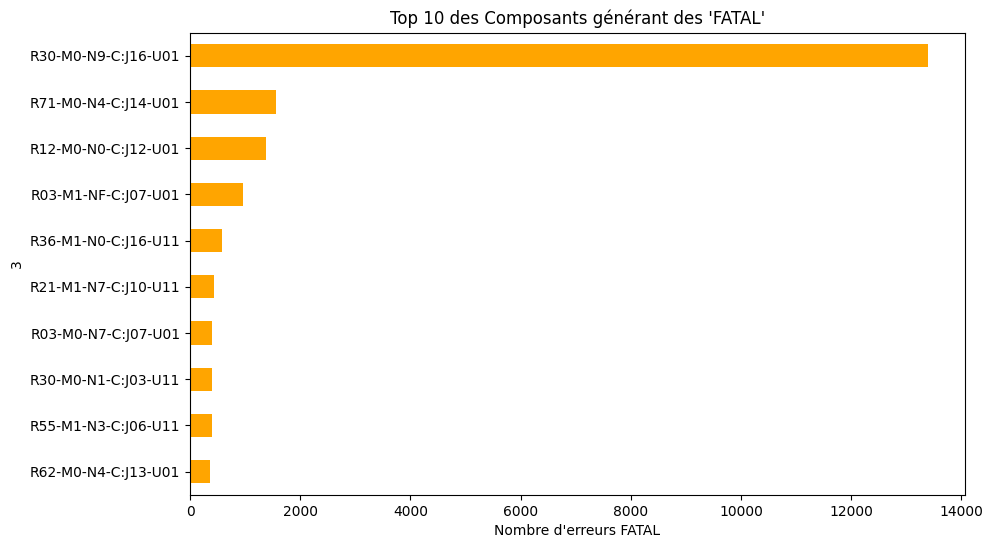

Génération du graphique 'Messages d'Erreur'...


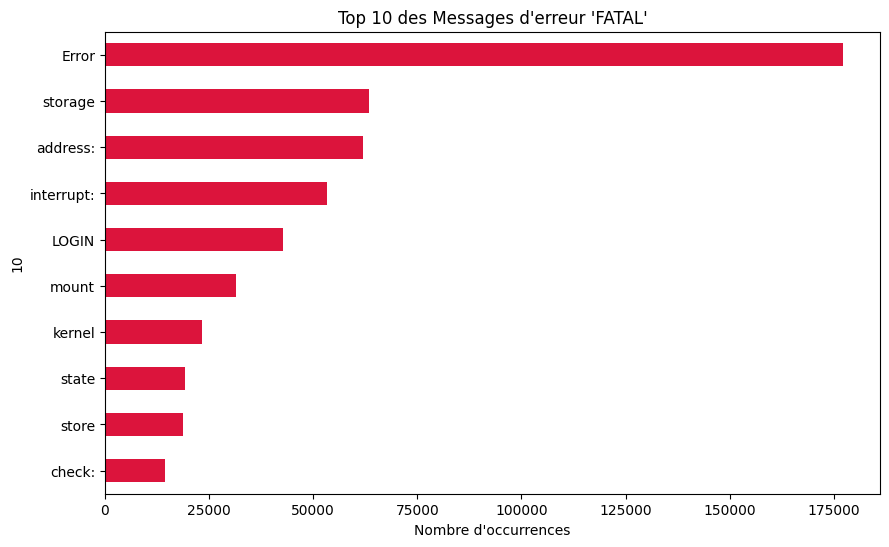

In [42]:
# --- Étape 6bis: Visualisation de la Cause Racine ---
# (À ajouter à la fin de votre Cellule 10)

import matplotlib.pyplot as plt

# 1. Graphique pour les Composants
if 'composants_coupables' in locals():
    print("Génération du graphique 'Composants Coupables'...")
    composants_coupables.head(10).plot(kind='barh',
                                     figsize=(10, 6),
                                     title="Top 10 des Composants générant des 'FATAL'",
                                     color='orange')
    plt.xlabel("Nombre d'erreurs FATAL")
    plt.gca().invert_yaxis() # Met le plus fréquent en haut
    #Inverse l'axe Y pour afficher la barre la plus longue en haut.

    # On sauvegarde le graphique
    plt.savefig('fatal_components_chart.png', bbox_inches='tight')
    # bbox_inches='tight' ajuste la taille pour que rien ne soit coupé.
    plt.show() # Affiche le graphique dans Colab

# 2. Graphique pour les Messages
if 'messages_erreur' in locals():
    print("Génération du graphique 'Messages d'Erreur'...")
    messages_erreur.head(10).plot(kind='barh',
                                figsize=(10, 6),
                                title="Top 10 des Messages d'erreur 'FATAL'",
                                color='crimson')
    plt.xlabel("Nombre d'occurrences")
    plt.gca().invert_yaxis()

    # On sauvegarde le graphique
    plt.savefig('fatal_messages_chart.png', bbox_inches='tight')
    plt.show() # Affiche le graphique dans Colab


## Conclusion du Projet

Ce notebook a démontré un cycle d'analyse complet sur un fichier de 4.7 millions de lignes, en surmontant la contrainte de la RAM grâce à une méthode de traitement par "chunks".

**Résultat de l'enquête :**

L'analyse a non seulement identifié **707 523 erreurs critiques (FATAL)**, mais a aussi pointé les coupables :

1.  **Composant principal :** `R30-M0-N9-C:J16-U01` est le composant le plus défaillant, responsable de 13 397 erreurs à lui seul.
2.  **Message principal :** Le message `Error` (177 220 occurrences) et `storage` (63 491 occurrences) sont les causes racines les plus fréquentes.

Ce diagnostic permet à une équipe technique de cibler ses efforts de réparation sur les composants et les types d'erreurs les plus impactants.

